In [ ]:
import pandas as pd
#def CSapiBuilder(): 
n = 7593 #number of total entries 
allpages =[]
for i in xrange(0, n):
    try:
        api ='https://api.data.gov/ed/collegescorecard/v1/schools.csv?fields=school.name,id,2013.aid.median_debt.completers.overall,2013.repayment.1_yr_repayment.completers,2013.earnings.10_yrs_after_entry.working_not_enrolled.mean_earnings&page=%s&api_key=7EfsgcFY3JfMxQJ7tAW0Cjqamb77iOHPbpdBXTP6' % str(n)
        df = pd.read_csv(api)
        allpages.append[df]
    except:
        pass

#api = "https://api.data.gov/ed/collegescorecard/v1/schools.csv?school.degrees_awarded.predominant=2,3&_fields=id,school.name,school.city,2015.student.size&api_key=7EfsgcFY3JfMxQJ7tAW0Cjqamb77iOHPbpdBXTP6"
#not sure how to modify API to return more than 20 hits
print(allpages.shape,allpages[0])
#print(df)

In [96]:
import glob
csv_files = glob.glob("./CollegeScorecard_Raw_Data/*.csv") 
print(csv_files) 
list_data = []
for filename in csv_files:
    data = pd.read_csv(filename,low_memory=False,na_values=-2)
    list_data.append(data)
pd.concat(list_data)

['./CollegeScorecard_Raw_Data/MERGED1996_97_PP.csv', './CollegeScorecard_Raw_Data/MERGED1997_98_PP.csv', './CollegeScorecard_Raw_Data/MERGED1998_99_PP.csv', './CollegeScorecard_Raw_Data/MERGED1999_00_PP.csv', './CollegeScorecard_Raw_Data/MERGED2000_01_PP.csv', './CollegeScorecard_Raw_Data/MERGED2001_02_PP.csv', './CollegeScorecard_Raw_Data/MERGED2002_03_PP.csv', './CollegeScorecard_Raw_Data/MERGED2003_04_PP.csv', './CollegeScorecard_Raw_Data/MERGED2004_05_PP.csv', './CollegeScorecard_Raw_Data/MERGED2005_06_PP.csv', './CollegeScorecard_Raw_Data/MERGED2006_07_PP.csv', './CollegeScorecard_Raw_Data/MERGED2007_08_PP.csv', './CollegeScorecard_Raw_Data/MERGED2008_09_PP.csv', './CollegeScorecard_Raw_Data/MERGED2009_10_PP.csv', './CollegeScorecard_Raw_Data/MERGED2010_11_PP.csv', './CollegeScorecard_Raw_Data/MERGED2011_12_PP.csv', './CollegeScorecard_Raw_Data/MERGED2012_13_PP.csv', './CollegeScorecard_Raw_Data/MERGED2013_14_PP.csv', './CollegeScorecard_Raw_Data/MERGED2014_15_PP.csv']


/Users/taniajogesh/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/taniajogesh/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (1,6,442,451,598,607,611,620,624,633,789,802,806,815,893,906,971,984,997,1153,1166,1407,1408,1411,1425,1431,1432,1433,1437,1438,1439,1440,1445,1446,1447,1451,1452,1453,1454,1459,1460,1461,1465,1466,1467,1468,1473,1474,1475,1479,1480,1481,1482,1487,1488,1489,1501,1502,1537,1538,1539,1540,1541,1542,1603,1606,1609,1610,1611,1613,1614,1615,1616,1688,1689,1690,1691,1692,1729) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/taniajogesh/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: C

,UNITID,OPEID,OPEID6,INSTNM,CITY,STABBR,ZIP,ACCREDAGENCY,INSTURL,NPCURL,...,D100_L4,TRANS_4,DTRANS_4,TRANS_L4,DTRANS_L4,ICLEVEL,UGDS_MEN,UGDS_WOMEN,CDR3_DENOM,CDR2_DENOM
0,100636,01230800,12308,COMMUNITY COLLEGE OF THE AIR FORCE,MONTGOMERY,AL,361126613,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2.0,0.8409,0.1591,NaN,0.0
1,100654,00100200,1002,Alabama A & M University,Normal,AL,35762,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,0.4808,0.5192,NaN,930.0
2,100663,00105200,1052,University of Alabama at Birmingham,Birmingham,AL,35294-0110,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,0.4322,0.5678,NaN,2286.0
3,100672,00574900,5749,ALABAMA AVIATION AND TECHNICAL COLLEGE,OZARK,AL,36360,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2.0,0.8847,0.1153,NaN,48.0
4,100690,02503400,25034,Amridge University,Montgomery,AL,36117-3553,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,0.7667,0.2333,NaN,31.0
5,100706,00105500,1055,University of Alabama in Huntsville,Huntsville,AL,35899,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,0.4904,0.5096,NaN,586.0
6,100724,00100500,1005,Alabama State University,Montgomery,AL,36104-0271,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,0.4353,0.5647,NaN,1219.0
7,100751,00105100,1051,The University of Alabama,Tuscaloosa,AL,35487-0166,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,0.4767,0.5233,NaN,2591.0
8,100760,00100700,1007,Central Alabama Community College,Alexander City,AL,35010,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2.0,0.3878,0.6122,NaN,0.0
9,100812,00100800,1008,Athens State University,Athens,AL,35611,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,0.3766,0.6234,NaN,220.0


In [42]:
import pandas as pd
# read in the 2015 data for now (I may later concatenate all years into a single dataframe)
filepath ='./CollegeScorecard_Raw_Data/MERGED2014_15_PP.csv'
AllData_2015 = pd.read_csv(filepath, low_memory=False,na_values=-2)
#reading in a text with only variables of interest 
Allvariables = pd.read_csv('coreVariables.csv')
# convert df to a list of variables 
variables = list(Allvariables.iloc[:,5])
#removing all extreneous columns and only keeping 'variables'
Relevant_data_2015 = AllData_2015.loc[:,variables]
#changing the column names to names that are a little more intuitive to read 
Relevant_data_2015.columns = list(Allvariables['my_classification'])


In [105]:
print(Relevant_data_2015.shape) #number of records
#make sure all numeric columns are numeric
print(Relevant_data_2015.info())

(7703, 48)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7703 entries, 0 to 7702
Data columns (total 48 columns):
id                                      7703 non-null int64
name                                    7703 non-null object
locale                                  7282 non-null object
carnegie_basic                          4619 non-null object
sat_scores                              1304 non-null float64
prop_white                              6990 non-null float64
prop_black                              6990 non-null float64
prop_hispanic                           6990 non-null float64
prop_asian                              6990 non-null float64
prop_aian                               6990 non-null float64
prop_nhpi                               6990 non-null float64
prop_two_or_more                        6990 non-null float64
prop_non_resident_alien                 6990 non-null float64
prop_unknown                            6990 non-null float64
prop_white_non_hisp

In [99]:
#the following columns should be ints but they are not so look at values and replace strings with NANs
#avg_family_income_dependent
#avg_family_income_independent
#loan_principal
#print(Relevant_data_2015['loan_principal'].value_counts(dropna=False))

#print(Relevant_data_2015['avg_family_income_independent'].value_counts(dropna=False))
#print(Relevant_data_2015['avg_family_income_dependent'].value_counts(dropna=False))
# In all three need to replace PrivacySuppressed with NANS

#not sure how to convert to ints after

Relevant_data_2015.loan_principal.replace('PrivacySuppressed',None,inplace=True)
Relevant_data_2015.avg_family_income_independent.replace('PrivacySuppressed',None,inplace=True)
Relevant_data_2015.avg_family_income_dependent.replace('PrivacySuppressed',None,inplace=True)

Relevant_data_2015['loan_principal'] = Relevant_data_2015['loan_principal'].astype(float)
Relevant_data_2015['avg_family_income_independent'] = Relevant_data_2015['avg_family_income_independent'].astype(float)
Relevant_data_2015['avg_family_income_dependent'] = Relevant_data_2015['avg_family_income_dependent'].astype(float)
#Relevant_data_2015['loan_principal'].astype(int)

#Alternative option
#Relevant_data_2015['loan_principal'] = pd.to_numeric(Relevant_data_2015['loan_principal'],errors='coerce') 



 9500.0     1018
 5500.0      272
 12000.0     157
 13566.0     149
 6333.0      128
 3500.0      102
 15000.0      88
 19500.0      84
 9833.0       83
 12500.0      79
 4500.0       72
 6000.0       65
 18750.0      59
 19000.0      57
 10000.0      55
 6500.0       52
 21500.0      51
 20000.0      47
 7000.0       47
 4750.0       42
 7500.0       41
 14400.0      41
 13000.0      41
 12004.5      40
 7917.0       39
 12283.5      38
NaN           38
 11108.0      37
 16500.0      35
 10500.0      35
            ... 
 7520.0        1
 11513.0       1
 10704.5       1
 8538.0        1
 17525.0       1
 6725.0        1
 4575.0        1
 5766.0        1
 10699.5       1
 5114.5        1
 2651.5        1
 13031.0       1
 9804.0        1
 19168.0       1
 5008.0        1
 23192.5       1
 15186.0       1
 13286.0       1
 19097.0       1
 15684.0       1
 5061.0        1
 10924.0       1
 3325.0        1
 5534.5        1
 7323.0        1
 6098.0        1
 14625.0       1
 16429.0      

In [44]:
## Carnegie school type classification
carnegie = pd.read_csv('Carnegie_notations.csv', header=None)
carnegie_dict =dict(carnegie.values)
Relevant_data_2015["carnegie_basic"].replace(carnegie_dict, inplace=True)
print(Relevant_data_2015.carnegie_basic.value_counts(dropna=False))
# almost a thrid of the colleges are not classified 

NaN                                                                                             3084
Master's Colleges & Universities: Larger Programs                                                394
Baccalaureate Colleges: Diverse Fields                                                           322
Special Focus Four-Year: Faith-Related Institutions                                              295
Special Focus Two-Year: Health Professions                                                       265
Special Focus Four-Year: Other Health Professions Schools                                        260
Baccalaureate/Associate's Colleges: Mixed Baccalaureate/Associate's                              259
Baccalaureate Colleges: Arts & Sciences Focus                                                    243
Master's Colleges & Universities: Medium Programs                                                214
Associate's Colleges: High Vocational & Technical-High Nontraditional                      

In [47]:
## Carnegie undergrad classification
carnegie_ug = pd.read_csv('Carnegie_undergrad.csv', header=None)
carnegie_ug_dict =dict(carnegie_ug.values)
Relevant_data_2015["carnegie_undergrad"].replace(carnegie_ug_dict, inplace=True)
print(Relevant_data_2015.carnegie_undergrad.value_counts(dropna=False))
# almost a thrid of the colleges are not classified 
#remove all the graduate professional only colleges?

NaN                                                            3084
Four-year, full-time, inclusive, higher transfer-in             555
Two-year, higher part-time                                      508
Four-year, higher part-time                                     428
Two-year, mixed part/full-time                                  405
Two-year, higher full-time                                      392
Four-year, full-time, selective, higher transfer-in             329
Not classified (Exclusively Graduate)                           306
Four-year, medium full-time, inclusive, higher transfer-in      300
Four-year, full-time, more selective, lower transfer-in         292
Four-year, full-time, inclusive, lower transfer-in              271
Two-year, medium full-time                                      268
Four-year, medium full-time, inclusive, lower transfer-in       150
Four-year, medium full-time , selective, higher transfer-in     148
Four-year, full-time, selective, lower transfer-

In [49]:
## Carnegie size classification
carnegie_sz = pd.read_csv('Carnegie_size.csv', header=None)
carnegie_sz_dict =dict(carnegie_sz.values)
Relevant_data_2015["carnegie_size_setting"].replace(carnegie_sz_dict, inplace=True)
print(Relevant_data_2015.carnegie_size_setting.value_counts(dropna=False))
# almost a thrid of the colleges are not classified 

NaN                                                3084
Four-year, very small, primarily nonresidential     818
Two-year, very small                                525
Two-year, small                                     470
Four-year, small, highly residential                332
Two-year, medium                                    329
Exclusively graduate/professional                   282
Four-year, small, primarily nonresidential          258
Four-year, very small, highly residential           236
Four-year, medium, primarily nonresidential         200
Four-year, small, primarily residential             187
Two-year, large                                     174
Four-year, medium, primarily residential            171
Four-year, large, primarily nonresidential          141
Four-year, medium, highly residential               139
Four-year, large, primarily residential             124
Four-year, very small, primarily residential        119
Two-year, very large                            

In [45]:
## Urbanization classification
print(Relevant_data_2015.degree_urbanization.value_counts(dropna=False))
# almost a thrid of the colleges are not classified 
# this columnn is non-existance do remove from df 
Relevant_data_2015.drop('degree_urbanization', axis=1, inplace=True)



NaN    7703
Name: degree_urbanization, dtype: int64


In [46]:
## Locale classification
locale = pd.read_csv('urbanization.csv', header=None)
locale_dict =dict(locale.values)
Relevant_data_2015["locale"].replace(locale_dict, inplace=True)
#replace -3 with -2
Relevant_data_2015.locale.replace(-3,None,inplace=True)

print(Relevant_data_2015.locale.value_counts(dropna=False))
# almost a thrid of the colleges are not classified 
# this columnn is non-existance do remove from df 


Suburb: Large       1940
City: Large         1657
City: Small          984
City: Midsize        869
Town: Distant        454
NaN                  421
Rural: Fringe        381
Town: Remote         340
Suburb: Midsize      213
Suburb: Small        140
Town: Fringe         123
Rural: Distant       119
Rural: Remote         62
Name: locale, dtype: int64


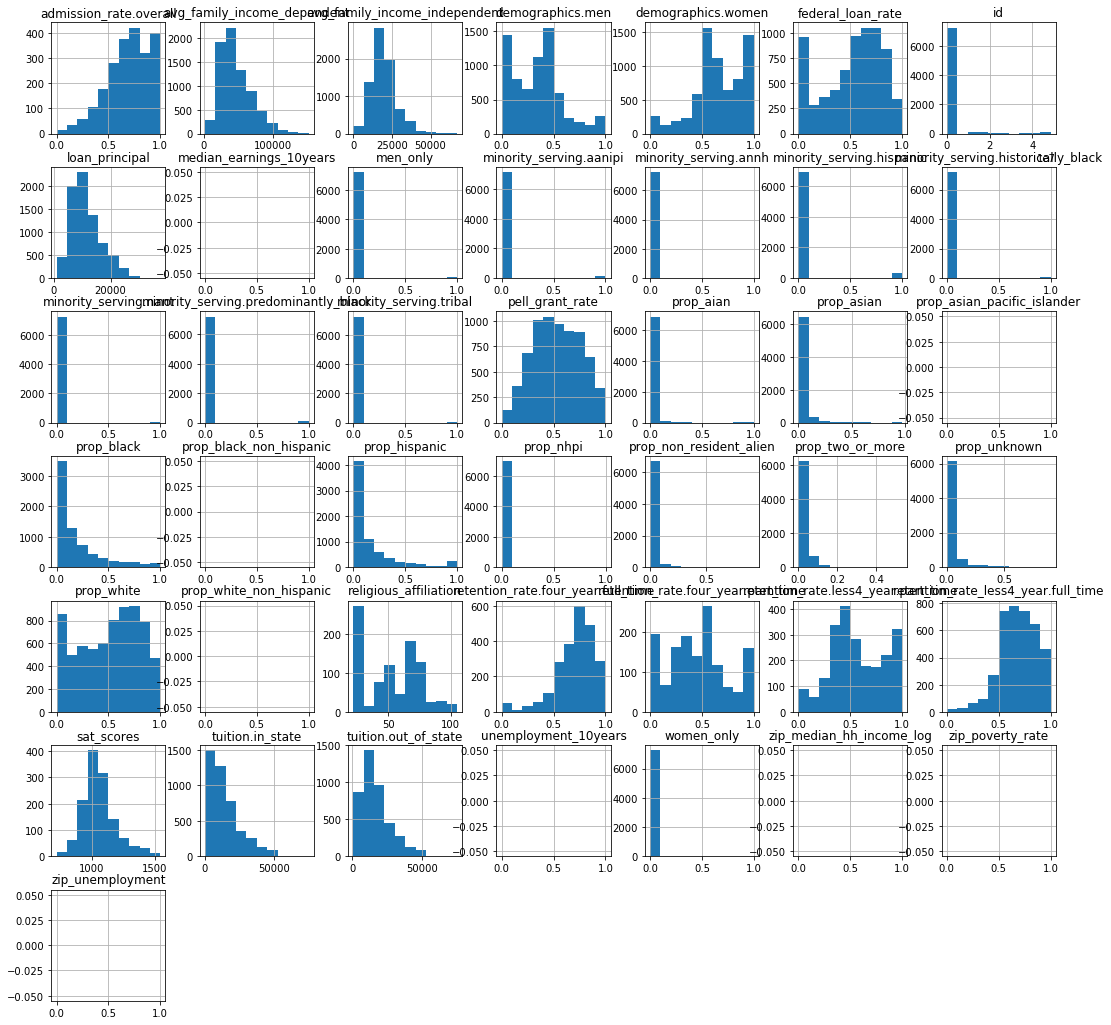

In [100]:
import matplotlib.pyplot as plt
%matplotlib inline  
# Plot the histogram
Relevant_data_2015.hist(figsize=(18, 18))
# Display the histogram
plt.show()

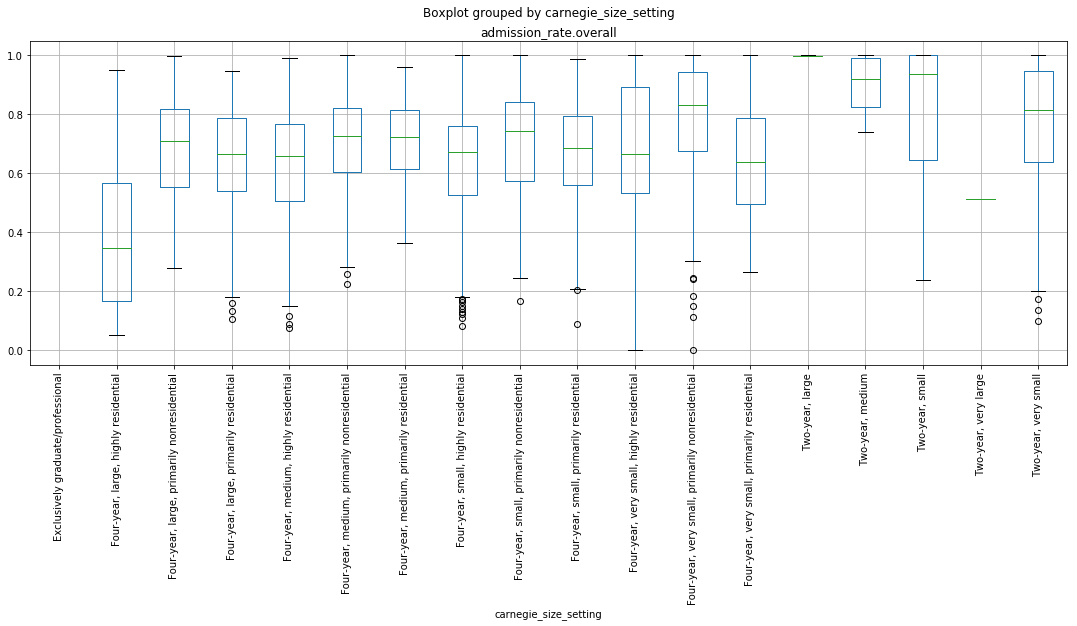

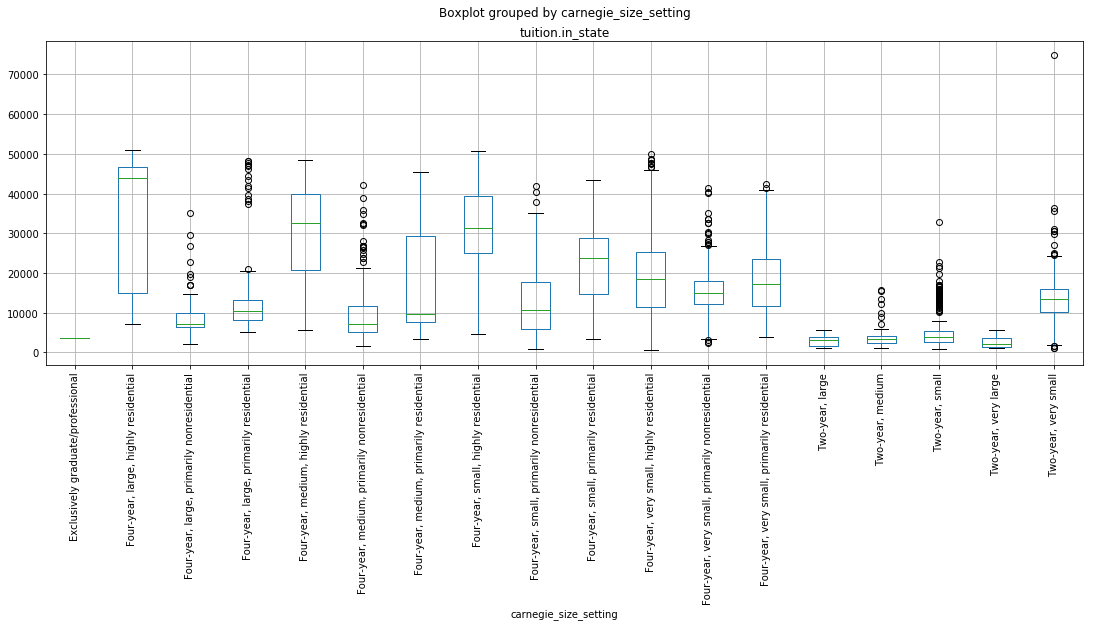

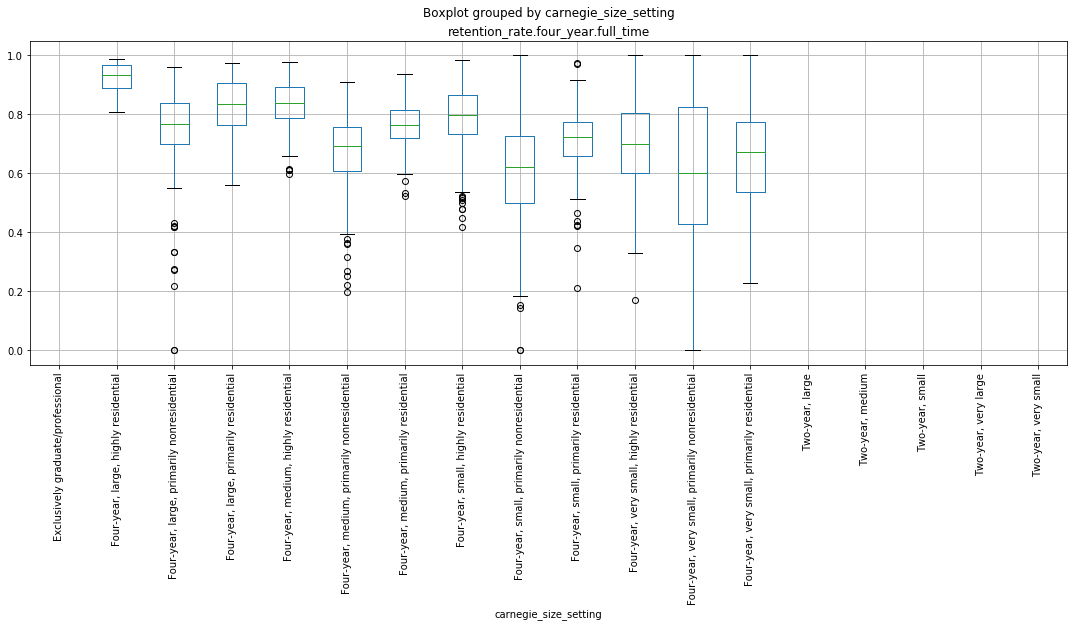

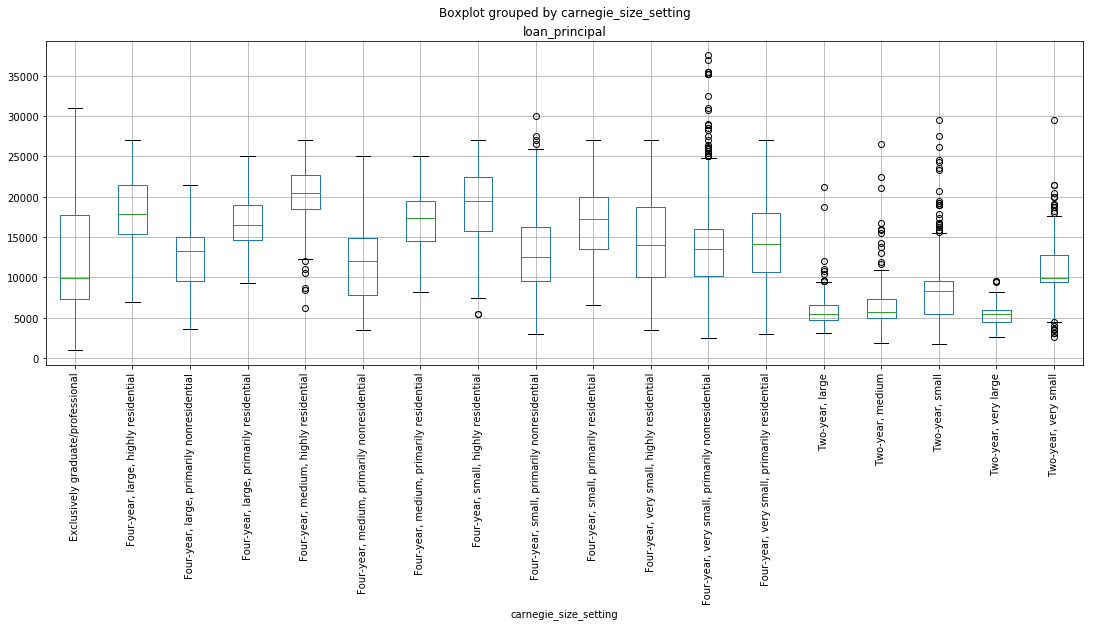

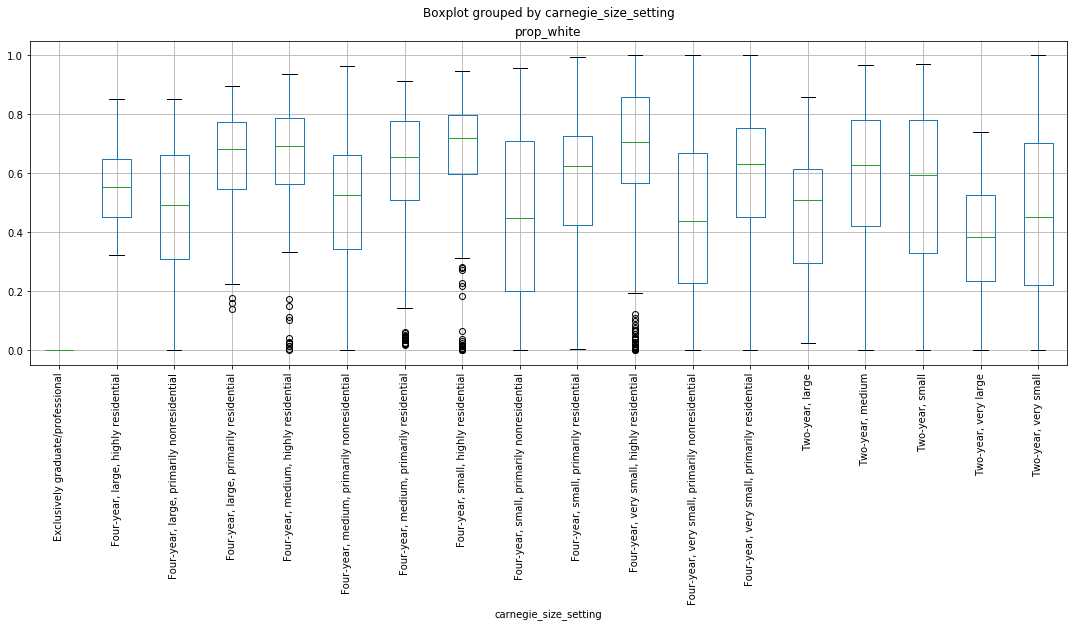

In [101]:
import matplotlib.pyplot as plt
%matplotlib inline  
# Plot the histogram
Relevant_data_2015.boxplot(column='admission_rate.overall', by='carnegie_size_setting', rot=90, figsize=(18, 6))
Relevant_data_2015.boxplot(column='tuition.in_state', by='carnegie_size_setting', rot=90, figsize=(18, 6))
Relevant_data_2015.boxplot(column='retention_rate.four_year.full_time', by='carnegie_size_setting', rot=90, figsize=(18, 6))
Relevant_data_2015.boxplot(column='loan_principal', by='carnegie_size_setting', rot=90, figsize=(18, 6))
Relevant_data_2015.boxplot(column='prop_white', by='carnegie_size_setting', rot=90, figsize=(18, 6))


#
# Display the histogram
plt.show()


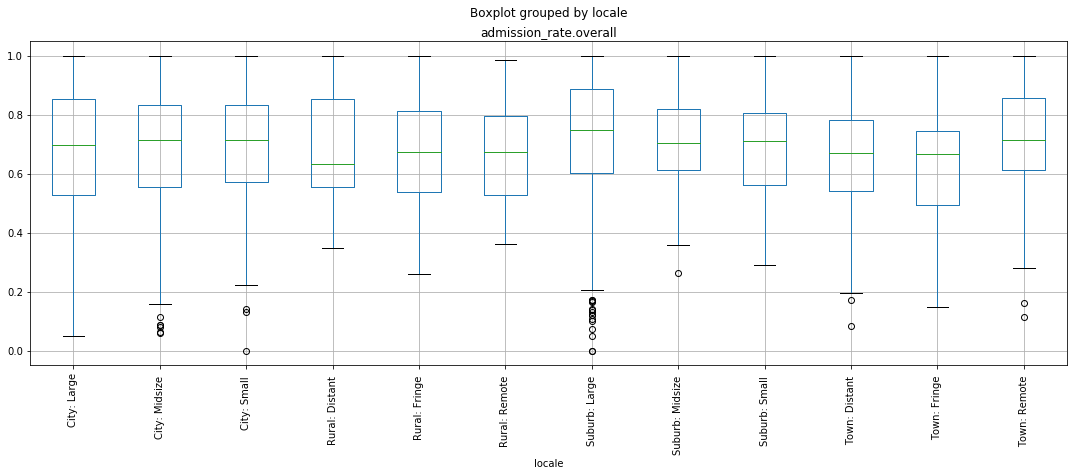

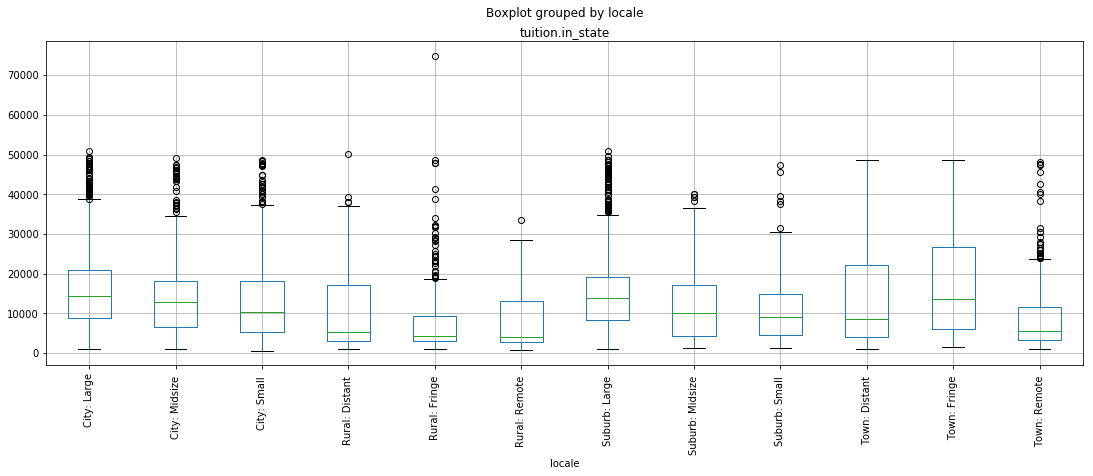

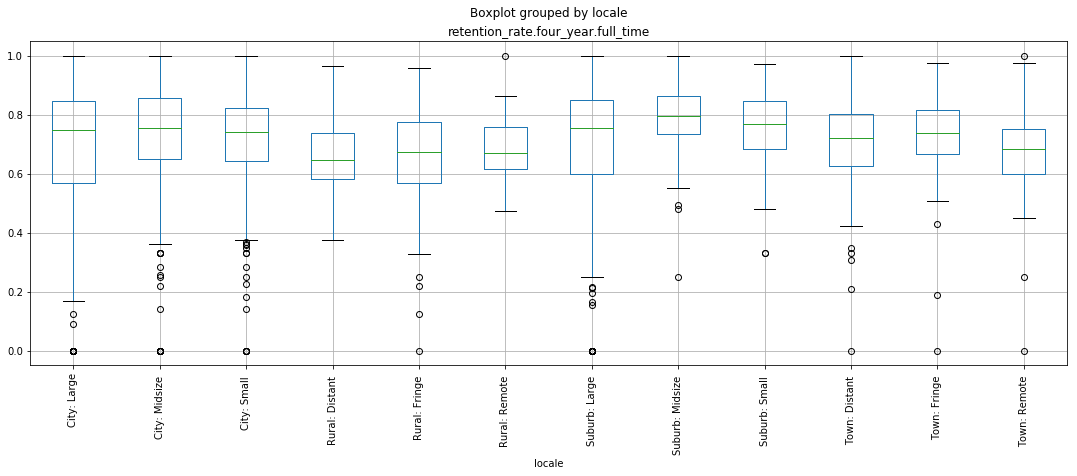

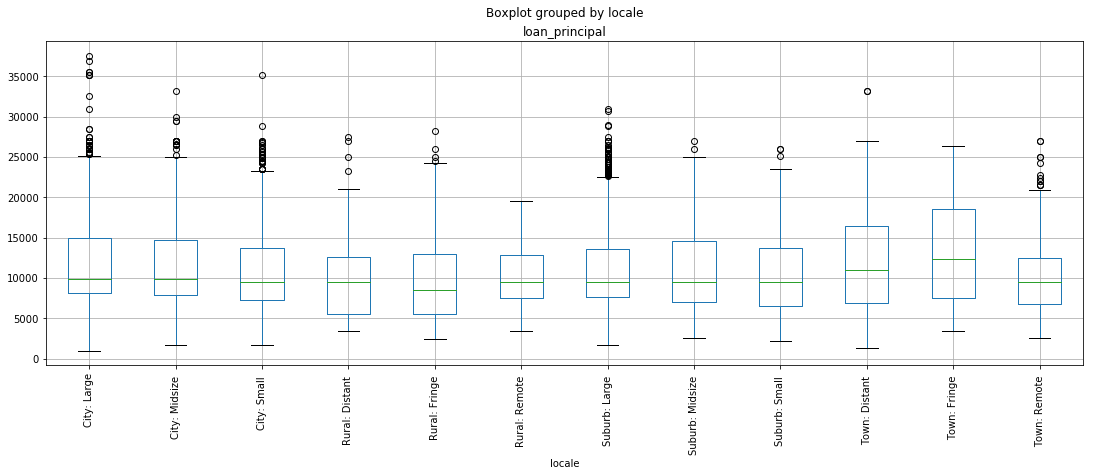

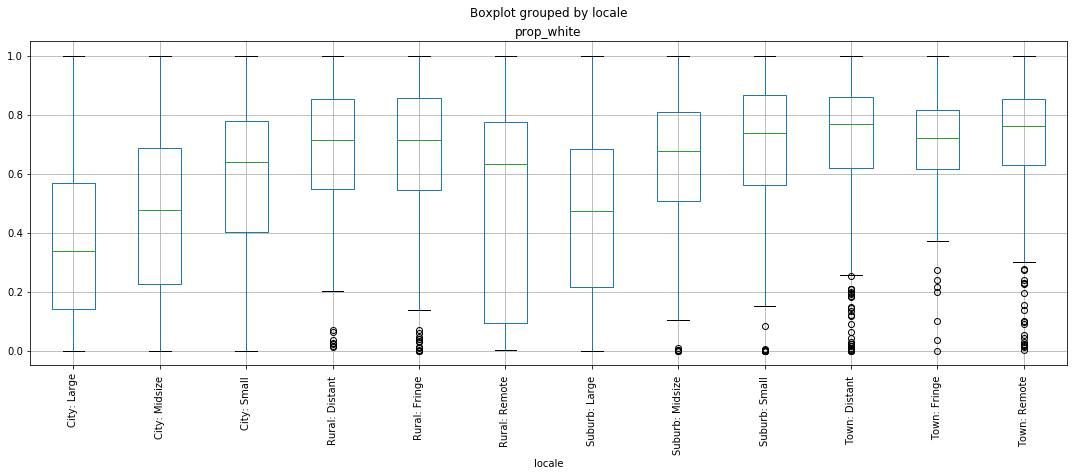

In [102]:
%matplotlib inline  
# Plot the histogram
Relevant_data_2015.boxplot(column='admission_rate.overall', by='locale', rot=90, figsize=(18, 6))
Relevant_data_2015.boxplot(column='tuition.in_state', by='locale', rot=90, figsize=(18, 6))
Relevant_data_2015.boxplot(column='retention_rate.four_year.full_time', by='locale', rot=90, figsize=(18, 6))
Relevant_data_2015.boxplot(column='loan_principal', by='locale', rot=90, figsize=(18, 6))
Relevant_data_2015.boxplot(column='prop_white', by='locale', rot=90, figsize=(18, 6))


#
# Display the histogram
plt.show()


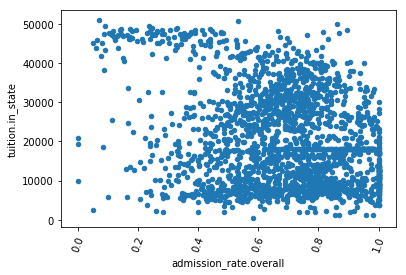

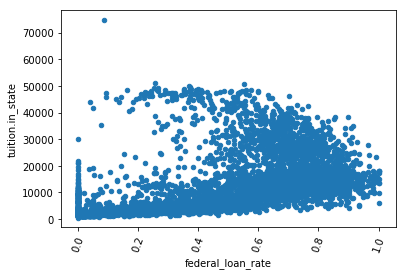

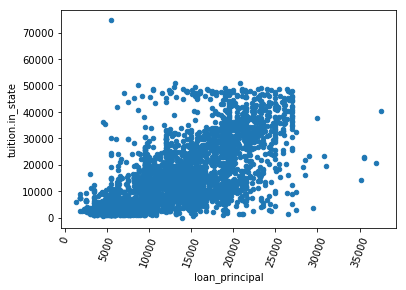

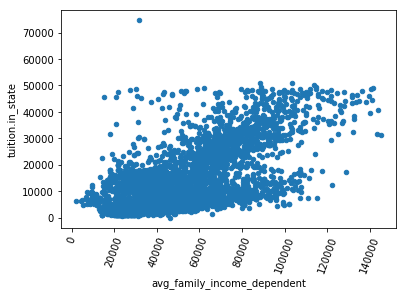

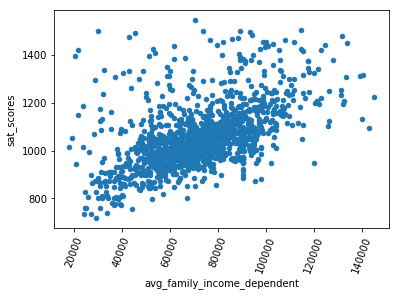

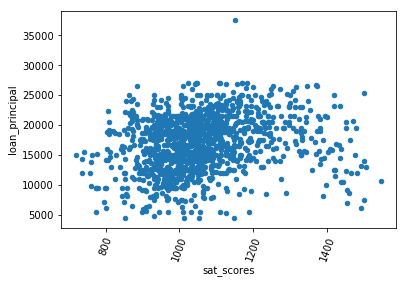

In [108]:

%matplotlib inline  
Relevant_data_2015.plot(kind='scatter', x='admission_rate.overall', y='tuition.in_state', rot=70)
Relevant_data_2015.plot(kind='scatter', x='federal_loan_rate', y='tuition.in_state', rot=70)
Relevant_data_2015.plot(kind='scatter', x='loan_principal', y='tuition.in_state', rot=70)
Relevant_data_2015.plot(kind='scatter', x='avg_family_income_dependent', y='tuition.in_state', rot=70)
Relevant_data_2015.plot(kind='scatter', x='avg_family_income_dependent', y='sat_scores', rot=70)
Relevant_data_2015.plot(kind='scatter', x='sat_scores', y='loan_principal', rot=70)

plt.show()
